In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"minghsieh0302","key":"03570f87f93cd62793b307a3485bd51a"}'}

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle kernels pull minghsieh0302/old-car-price-predcitions-ming

Source code downloaded to /content/old-car-price-predcitions-ming.ipynb


In [4]:
!kaggle datasets download -d milanvaddoriya/old-car-price-prediction

  0% 0.00/105k [00:00<?, ?B/s]
100% 105k/105k [00:00<00:00, 49.2MB/s]


In [5]:
! mkdir old-car-price-prediction

In [6]:
! unzip old-car-price-prediction.zip -d old-car-price-prediction

Archive:  old-car-price-prediction.zip
  inflating: old-car-price-prediction/car_price.csv  


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('old-car-price-prediction/car_price.csv')

print()
print("Data shape: " + str(df.shape))

display(df.head())
display(df.tail())


Data shape: (5512, 10)


,Unnamed: 0,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats
0,0,Jeep Compass 2.0 Longitude Option BSIV,10.03 Lakh,"86,226 kms",Diesel,Manual,1st Owner,2017,1956 cc,5 Seats
1,1,Renault Duster RXZ Turbo CVT,12.83 Lakh,"13,248 kms",Petrol,Automatic,1st Owner,2021,1330 cc,5 Seats
2,2,Toyota Camry 2.5 G,16.40 Lakh,"60,343 kms",Petrol,Automatic,1st Owner,2016,2494 cc,5 Seats
3,3,Honda Jazz VX CVT,7.77 Lakh,"26,696 kms",Petrol,Automatic,1st Owner,2018,1199 cc,5 Seats
4,4,Volkswagen Polo 1.2 MPI Highline,5.15 Lakh,"69,414 kms",Petrol,Manual,1st Owner,2016,1199 cc,5 Seats


,Unnamed: 0,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats
5507,5507,BMW X1 sDrive 20d xLine,28.90 Lakh,"45,000 kms",Diesel,Automatic,1st Owner,2018,2995 cc,7 Seats
5508,5508,BMW M Series M4 Coupe,64.90 Lakh,"29,000 kms",Petrol,Automatic,2nd Owner,2015,1968 cc,5 Seats
5509,5509,Jaguar XF 2.2 Litre Luxury,13.75 Lakh,"90,000 kms",Diesel,Automatic,2nd Owner,2013,2755 cc,5 Seats
5510,5510,BMW 7 Series 730Ld,29.90 Lakh,"79,000 kms",Diesel,Automatic,3rd Owner,2015,2967 cc,6 Seats
5511,5511,BMW 5 Series 520d M Sport,31.90 Lakh,"42,000 kms",Diesel,Automatic,2nd Owner,2017,1991 cc,5 Seats


## Data Preprocessing - Simple

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5512 entries, 0 to 5511
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           5512 non-null   int64 
 1   car_name             5512 non-null   object
 2   car_prices_in_rupee  5512 non-null   object
 3   kms_driven           5512 non-null   object
 4   fuel_type            5512 non-null   object
 5   transmission         5512 non-null   object
 6   ownership            5512 non-null   object
 7   manufacture          5512 non-null   int64 
 8   engine               5512 non-null   object
 9   Seats                5512 non-null   object
dtypes: int64(2), object(8)
memory usage: 430.8+ KB


In [10]:
df[df.duplicated()].count()

Unnamed: 0             0
car_name               0
car_prices_in_rupee    0
kms_driven             0
fuel_type              0
transmission           0
ownership              0
manufacture            0
engine                 0
Seats                  0
dtype: int64

### 1. Split brand name from "car_name"  
Different brands have their own "Brand Value",so split the brand name might help we predict the car price.

In [11]:
newcols = df["car_name"].str.split(" ",n=1)
newcols.index = df.index
df.insert(1,"Brand","")
for i in range(5512):
    df["Brand"][i] = newcols[i][0]
    df["car_name"][i] = newcols[i][1]
df.head()

,Unnamed: 0,Brand,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats
0,0,Jeep,Compass 2.0 Longitude Option BSIV,10.03 Lakh,"86,226 kms",Diesel,Manual,1st Owner,2017,1956 cc,5 Seats
1,1,Renault,Duster RXZ Turbo CVT,12.83 Lakh,"13,248 kms",Petrol,Automatic,1st Owner,2021,1330 cc,5 Seats
2,2,Toyota,Camry 2.5 G,16.40 Lakh,"60,343 kms",Petrol,Automatic,1st Owner,2016,2494 cc,5 Seats
3,3,Honda,Jazz VX CVT,7.77 Lakh,"26,696 kms",Petrol,Automatic,1st Owner,2018,1199 cc,5 Seats
4,4,Volkswagen,Polo 1.2 MPI Highline,5.15 Lakh,"69,414 kms",Petrol,Manual,1st Owner,2016,1199 cc,5 Seats


### 2. Transform the currency value  
I'm in Taiwan ,so if the price could show the number in local currency,   
it could not only compare in low or high price but show exactly the cost. 
  
．1 rupee is about 0.37 NT dollars
．Lakh = 100K，so 1Lakh rupee is about  37193 NT dollars  
．Crore  = Ten million ,1 crore rupee is about 3712136 NT dollars

In [12]:
for j,item in enumerate(df["car_prices_in_rupee"]): 
    if "Lakh" in item:
       df["car_prices_in_rupee"][j] = df["car_prices_in_rupee"][j].strip("Lakh")
       #print(j,",",df["car_prices_in_rupee"][j],type(df["car_prices_in_rupee"][j]))
       df["car_prices_in_rupee"][j]=pd.to_numeric(df["car_prices_in_rupee"][j])
       df["car_prices_in_rupee"][j]= round((df["car_prices_in_rupee"][j]*37193),2)
    elif "Crore" in item:
        df["car_prices_in_rupee"][j] = df["car_prices_in_rupee"][j].strip("Crore")
        #print(df["car_prices_in_rupee"][j])
        df["car_prices_in_rupee"][j]=pd.to_numeric(df["car_prices_in_rupee"][j])
        df["car_prices_in_rupee"][j]= round((df["car_prices_in_rupee"][j]*3712136),2)
    else: 
        df["car_prices_in_rupee"][j] = df["car_prices_in_rupee"][j].replace(",","")
        df["car_prices_in_rupee"][j]= pd.to_numeric(df["car_prices_in_rupee"][j])
        df["car_prices_in_rupee"][j]= round((df["car_prices_in_rupee"][j]*0.37),2)
        
df.rename(columns={'car_prices_in_rupee': 'car_prices_in_NT', 
                           }, inplace=True)

In [13]:
df["car_prices_in_NT"] = (df["car_prices_in_NT"]/10000).astype('float')
df["car_prices_in_NT"] = df["car_prices_in_NT"].round(2)
df.rename(columns={'car_prices_in_NT': 'car_prices', 
                           }, inplace=True)
df.insert(4,"multiply NT","10K")
df.head()

,Unnamed: 0,Brand,car_name,car_prices,multiply NT,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats
0,0,Jeep,Compass 2.0 Longitude Option BSIV,37.30,10K,"86,226 kms",Diesel,Manual,1st Owner,2017,1956 cc,5 Seats
1,1,Renault,Duster RXZ Turbo CVT,47.72,10K,"13,248 kms",Petrol,Automatic,1st Owner,2021,1330 cc,5 Seats
2,2,Toyota,Camry 2.5 G,61.00,10K,"60,343 kms",Petrol,Automatic,1st Owner,2016,2494 cc,5 Seats
3,3,Honda,Jazz VX CVT,28.90,10K,"26,696 kms",Petrol,Automatic,1st Owner,2018,1199 cc,5 Seats
4,4,Volkswagen,Polo 1.2 MPI Highline,19.15,10K,"69,414 kms",Petrol,Manual,1st Owner,2016,1199 cc,5 Seats


### 3. Dealing with "unit" in data, and transform the data type into numeric

In [14]:
df["kms_driven"] = df["kms_driven"].str.strip("kms")
df["kms_driven"] = df["kms_driven"].str.replace(",","")

df['Seats']=df['Seats'].str.replace(' Seats','')

df['engine']=df['engine'].str.replace(' cc','')

df["ownership"] = df["ownership"].str.strip("Owner")
for i,item in  enumerate(df["ownership"]):
    df["ownership"][i] = df["ownership"][i][0]

In [15]:
df['kms_driven']=df['kms_driven'].astype('int')
df['Seats']=df['Seats'].astype('int')
df['engine']=df['engine'].astype('int')
df['ownership']=df['ownership'].astype('int')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5512 entries, 0 to 5511
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    5512 non-null   int64  
 1   Brand         5512 non-null   object 
 2   car_name      5512 non-null   object 
 3   car_prices    5512 non-null   float64
 4   multiply NT   5512 non-null   object 
 5   kms_driven    5512 non-null   int64  
 6   fuel_type     5512 non-null   object 
 7   transmission  5512 non-null   object 
 8   ownership     5512 non-null   int64  
 9   manufacture   5512 non-null   int64  
 10  engine        5512 non-null   int64  
 11  Seats         5512 non-null   int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 516.9+ KB


## Data Preprocessing - Complex

### 1. Engine Size  
According to the classification of Vehicle License Tax (9 seats below) in Taiwan, we can differentiate the "engine" data into several levels

![image.png](attachment:3194e4e0-434f-4da5-8af8-d85fcce5d3d1.png)

In [17]:
#There are some data have no "engine" information, their data show "0".  
df[df["engine"]==0]

,Unnamed: 0,Brand,car_name,car_prices,multiply NT,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats
288,288,Tata,Nexon EV Prime XZ Plus LUX,15.55,10K,24374,Electric,Automatic,1,2021,0,5
311,311,Mahindra,e2o T2,11.94,10K,54112,Electric,Automatic,1,2014,0,5
630,630,BMW,X1 sDrive 20d xLine,162.72,10K,22000,Diesel,Automatic,1,2020,0,5
746,746,Maruti,Wagon R VXI BS IV,8.78,10K,100527,Petrol,Manual,1,2012,0,5
1212,1212,Tata,Harrier XM,46.86,10K,33500,Diesel,Manual,1,2019,0,5
1548,1548,Renault,KWID Climber 1.0 AMT BSIV,17.48,10K,30000,Petrol,Automatic,1,2019,0,5
1758,1758,Honda,City i-VTEC CVT VX,35.33,10K,65855,Petrol,Automatic,1,2019,0,5
1944,1944,Honda,City E,11.16,10K,77132,Petrol,Manual,1,2012,0,5
1968,1968,Kia,Seltos HTE D,43.96,10K,35343,Diesel,Manual,1,2021,0,5
2175,2175,Honda,CR-V 2.0L 2WD AT,57.65,10K,74000,Petrol,Automatic,1,2016,0,7


In [18]:
#Find out the range of "engine"
print("min:",df[df["engine"]!=0]["engine"].min(),"max:",df["engine"].max())

min: 624 max: 5950


In [19]:
df.insert(11,"engine_class","")
for i,size in enumerate (df["engine"]):
    if size == 0:
        df["engine_class"][i] = 0
    elif size <=1200:
        df["engine_class"][i] = 1
    elif 1201<= size <=1800:
        df["engine_class"][i] = 2
    elif 1801<= size <=2400:
        df["engine_class"][i] = 3
    elif 2401<= size <=3000:
        df["engine_class"][i] = 4
    elif 3001<= size <=4200:
        df["engine_class"][i] = 5
    elif 4201<= size <=5400:
        df["engine_class"][i] = 6
    elif 5401<= size <=6600:
        df["engine_class"][i] = 7
df.sample(5)

,Unnamed: 0,Brand,car_name,car_prices,multiply NT,kms_driven,fuel_type,transmission,ownership,manufacture,engine,engine_class,Seats
1609,1609,BMW,X1 sDrive 20d xLine,120.88,10K,65000,Diesel,Automatic,1,2019,1248,2,5
2774,2774,Hyundai,Venue SX Plus Turbo DCT BSIV,36.60,10K,15224,Petrol,Automatic,1,2019,1198,1,7
317,317,Hyundai,Grand i10 AT Asta,21.39,10K,67000,Petrol,Automatic,1,2015,1197,1,5
1283,1283,Mercedes-Benz,C-Class C 220 CDI Avantgarde,46.31,10K,23000,Diesel,Automatic,1,2013,2993,4,5
388,388,Hyundai,i20 1.4 Asta Option,26.04,10K,90000,Diesel,Manual,1,2017,1396,2,5


In [20]:
# #Cause there is no duplicated material in this data, I decide to drop those information which df["engine"]==0
# df.drop(df[df["engine"]==0].index, inplace = True )
# df[df["engine"]==0]  

### 2. Brand Value  
According to the information onlie, we can also differentiate the "Band" data into several levels


參考資料 References    
TOP 《旗艦品牌》→金字塔"頂端"族群  
ROLLSROYCE(勞斯萊斯)、FERRARI(法拉利)、BENTLEY(賓利)、Lamborghini(藍寶堅尼)、ASTON MARTIN(亞斯頓馬汀)、MAYBACH(麥巴赫)、SALEEN(撒林)、BUGATTI(布嘉蒂)、MASERATI(瑪莎拉蒂)...

Premium《頂級品牌》→金字塔"上層"族群  
LEXUS(凌志)、Mercedes-Benz(賓士)、BMW(寶馬)、AUDI(奧迪)、JAGUAR(積架)、INFINITI(極限)、PORSCHE(保時捷)、LAND ROVER(陸虎、路華)、CADILLAC(凱迪拉克)、LINCOLN(林肯)、LOTUS(蓮花)  

Medium《中階品牌》→金字塔"中層"族群  
VOLVO(富豪)、SAAB(紳寶)、VW(福斯)、ACURA(謳歌)、JEEP(吉普)、SSANG YONG(雙龍)、BUICK(別克)、PEUGEOT(標誌)、RENALT(雷諾)、CHRYSLER(克萊斯勒)、MINI(迷你)、SMART(司麥特)、CITROEN(雪鐵龍)、KIA(起亞)  

Normal入門品牌  →金字塔"下層"族群
TOYOTA(豐田)、NISSAN(日產)、MITSUBISHI(三菱)、MAZDA(馬自達)、FORD(福特)、HYUNDAI(現代)、SUBARU(速罷陸)、ISUZU(五十鈴)、OPEL(歐寶)、SUZUKI(鈴木)、FORMOSA(台塑)、HONDA(本田)

In [21]:
car_brand = {'LV1':["Toyota","Nissan","Mitsubishi","Ford","Hyundai","Isuzu","Honda","Datsun","Fiat","Kia","MG","Mahindra","Maruti","Premier","Tata","Renault","Force"],
             'LV2':["Jeep","Lexus","Mini","Skoda","Volkswagen","Volvo"],
             'LV3':["Audi","BMW","Chevrolet","Jaguar","Land","Mercedes-Benz","Porsche"],
             'LV4':["Bentley","Maserati"]}

df.insert(2,"Brand_lv","")
for i,brand in enumerate (df["Brand"]):
    if brand in car_brand['LV1']:
        df["Brand_lv"][i] = 0
    elif brand in car_brand['LV2']:
        df["Brand_lv"][i] = 1
    elif brand in car_brand['LV3']:
        df["Brand_lv"][i] = 2
    elif brand in car_brand['LV4']:
        df["Brand_lv"][i] = 3
    else:
        print(brand)
    
df["Brand_lv"].value_counts()

0    4337
2     793
1     376
3       6
Name: Brand_lv, dtype: int64

### 3. Mapping fuel_type and transmission


In [22]:
# df["fuel_type"] = df["fuel_type"].map({"Petrol":0,"Diesel":1,"Cng":2,"Lpg":3,"Electric":4})
# df["transmission"] = df["transmission"].map({"Manual":0,"Automatic":1})
# df.head()

### 4. Convert the "manufacture" year into car's unsing age 

In [23]:
df.insert(11,"Age","")
df["Age"] = 2023 - df["manufacture"]
df.head()

,Unnamed: 0,Brand,Brand_lv,car_name,car_prices,multiply NT,kms_driven,fuel_type,transmission,ownership,manufacture,Age,engine,engine_class,Seats
0,0,Jeep,1,Compass 2.0 Longitude Option BSIV,37.30,10K,86226,Diesel,Manual,1,2017,6,1956,3,5
1,1,Renault,0,Duster RXZ Turbo CVT,47.72,10K,13248,Petrol,Automatic,1,2021,2,1330,2,5
2,2,Toyota,0,Camry 2.5 G,61.00,10K,60343,Petrol,Automatic,1,2016,7,2494,4,5
3,3,Honda,0,Jazz VX CVT,28.90,10K,26696,Petrol,Automatic,1,2018,5,1199,1,5
4,4,Volkswagen,1,Polo 1.2 MPI Highline,19.15,10K,69414,Petrol,Manual,1,2016,7,1199,1,5


### 5. Transform the data type into numeric

In [24]:
df["Brand_lv"]= df["Brand_lv"].astype("int")
df["Age"]= df["Age"].astype("int")
df["engine_class"]= df["engine_class"].astype("int")

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5512 entries, 0 to 5511
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    5512 non-null   int64  
 1   Brand         5512 non-null   object 
 2   Brand_lv      5512 non-null   int64  
 3   car_name      5512 non-null   object 
 4   car_prices    5512 non-null   float64
 5   multiply NT   5512 non-null   object 
 6   kms_driven    5512 non-null   int64  
 7   fuel_type     5512 non-null   object 
 8   transmission  5512 non-null   object 
 9   ownership     5512 non-null   int64  
 10  manufacture   5512 non-null   int64  
 11  Age           5512 non-null   int64  
 12  engine        5512 non-null   int64  
 13  engine_class  5512 non-null   int64  
 14  Seats         5512 non-null   int64  
dtypes: float64(1), int64(9), object(5)
memory usage: 646.1+ KB


## Cleaning data

In [26]:
df2 = df.copy()

#Cause there is no duplicated material in this data, I decide to drop those information which df["engine"]==0
df2.drop(df2[df2["engine"]==0].index, inplace = True )

df2.drop(["Unnamed: 0","Brand","manufacture","engine"],axis=1,inplace=True)
df2.sample(10)

,Brand_lv,car_name,car_prices,multiply NT,kms_driven,fuel_type,transmission,ownership,Age,engine_class,Seats
2342,0,Koleos 2.0 Diesel,18.60,10K,121000,Diesel,Automatic,2,11,2,7
5264,2,A6 35 TFSI Matrix,136.68,10K,30000,Petrol,Automatic,1,5,3,5
1195,0,Corolla Altis VL AT,32.54,10K,99300,Petrol,Automatic,2,8,4,5
4192,2,C-Class Progressive C 200,158.07,10K,28000,Petrol,Automatic,1,4,1,5
2971,0,Bolero Power Plus SLE,19.41,10K,67918,Diesel,Manual,1,7,2,5
260,0,i10 Magna,11.94,10K,89000,Petrol,Manual,1,10,1,5
1335,1,XC60 B5 Inscripition,254.77,10K,7000,Petrol,Automatic,1,1,5,7
4765,0,Ecosport Sports Diesel,40.65,10K,50044,Diesel,Manual,1,2,1,5
3507,0,City i VTEC V,23.95,10K,55802,Petrol,Manual,1,6,3,5
517,0,i20 Sportz 1.2,19.82,10K,33389,Petrol,Manual,1,8,2,5


## Data Analysis

In [27]:
df2.head()

,Brand_lv,car_name,car_prices,multiply NT,kms_driven,fuel_type,transmission,ownership,Age,engine_class,Seats
0,1,Compass 2.0 Longitude Option BSIV,37.30,10K,86226,Diesel,Manual,1,6,3,5
1,0,Duster RXZ Turbo CVT,47.72,10K,13248,Petrol,Automatic,1,2,2,5
2,0,Camry 2.5 G,61.00,10K,60343,Petrol,Automatic,1,7,4,5
3,0,Jazz VX CVT,28.90,10K,26696,Petrol,Automatic,1,5,1,5
4,1,Polo 1.2 MPI Highline,19.15,10K,69414,Petrol,Manual,1,7,1,5


In [28]:
sns.set(style="white") # darkgrid, whitegrid, dark, white, ticks

Text(0.5, 1.0, 'Transmission type popularity')

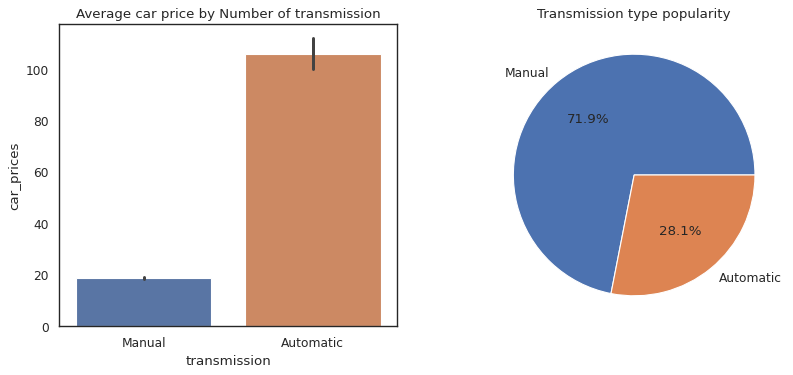

In [29]:
#Transmission

plt.figure(figsize=(12, 5), dpi=80)
plt.subplot(1, 2, 1) 
ax = sns.barplot(x="transmission", y='car_prices', data=df2)
ax.set_title('Average car price by Number of transmission')

trans = df2["transmission"].copy()
count = trans.value_counts()
#print(count)
plt.subplot(1, 2, 2)
plt.pie(x=count,autopct='%.1f%%',labels = ["Manual","Automatic"])
plt.title('Transmission type popularity')


Text(0.5, 1.0, 'Transmission type popularity')

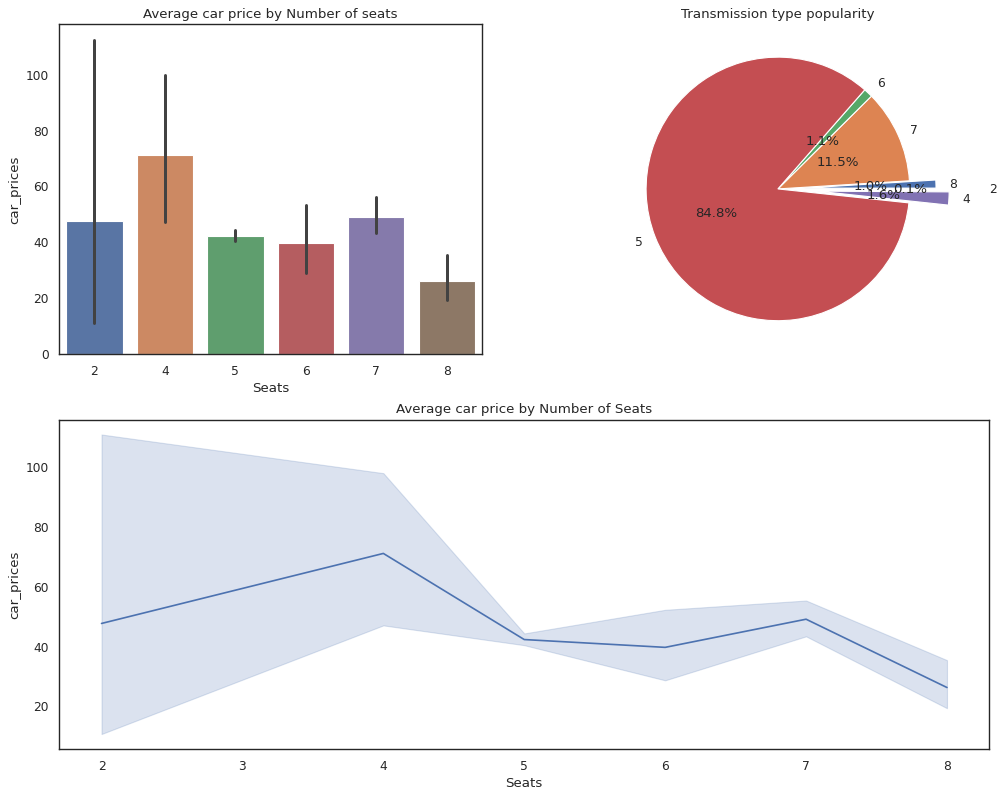

In [130]:
#Seats
plt.figure(figsize=(15, 12), dpi=80)

plt.subplot(2, 1, 2)
ax1= sns.lineplot(x="Seats", y='car_prices', data=df2)
ax1.set_title('Average car price by Number of Seats')

plt.subplot(2, 2, 1) 
ax2 = sns.barplot(x="Seats", y='car_prices', data=df2)
ax2.set_title('Average car price by Number of seats')

seat = df2["Seats"].copy()
count = seat.value_counts().sort_index(ascending=False)
#print(count)
plt.subplot(2, 2, 2)
plt.pie(x=count,autopct='%.1f%%',labels = ["8","7","6","5","4","2"],pctdistance=0.5,explode= [0.2,0,0,0,0.3,0.5])
plt.title('Transmission type popularity')

5      12
4      84
3     359
2    1314
1    3724
0       7
Name: ownership, dtype: int64


Text(0.5, 1.0, 'Ownership type popularity')

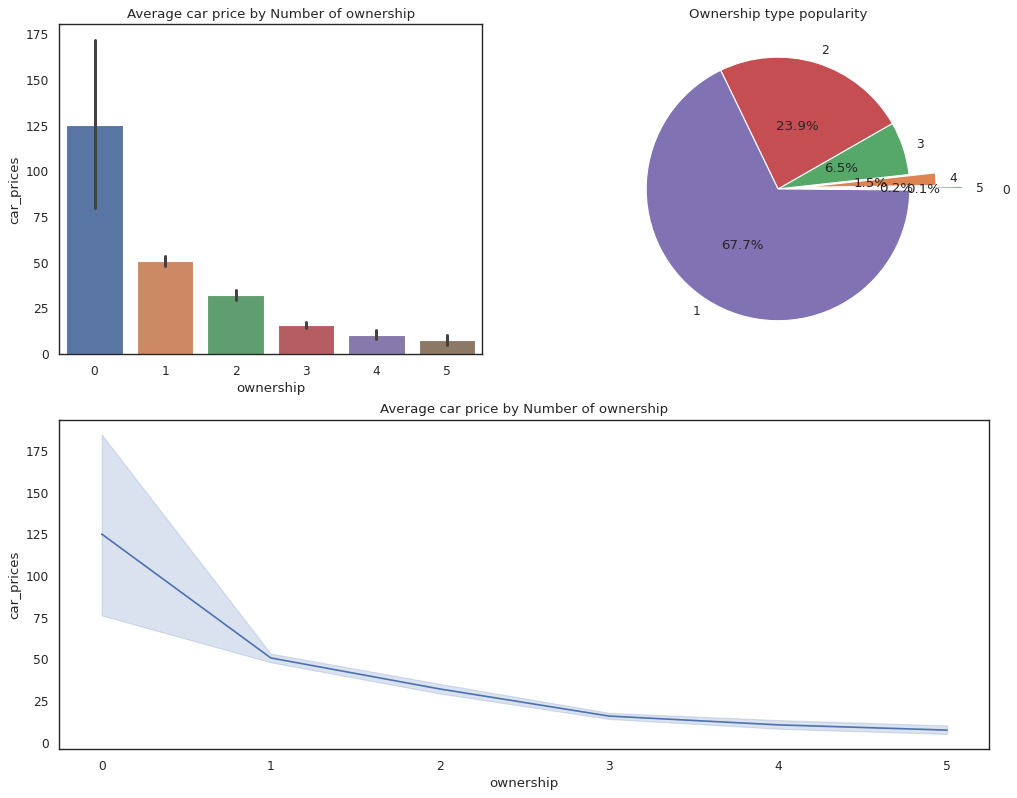

In [129]:
#ownershih
plt.figure(figsize=(15, 12), dpi=80)

plt.subplot(2, 1, 2)
pv2=sns.lineplot(x="ownership", y='car_prices', data=df2)
pv2.set_title('Average car price by Number of ownership')

plt.subplot(2, 2, 1) 
ax = sns.barplot(x="ownership", y='car_prices', data=df2)
ax.set_title('Average car price by Number of ownership')

ownership = df2["ownership"].copy()
count = ownership.value_counts().sort_index(ascending=False)
print(count)
plt.subplot(2, 2, 2)
plt.pie(x=count,autopct='%.1f%%',labels = ["5","4","3","2","1","0"],pctdistance=0.5,explode= [0.4,0.2,0,0,0,0.6])
plt.title('Ownership type popularity')

Petrol      2962
Lpg           28
Electric      12
Diesel      2418
Cng           80
Name: fuel_type, dtype: int64


Text(0.5, 1.0, 'Fuel_type type popularity')

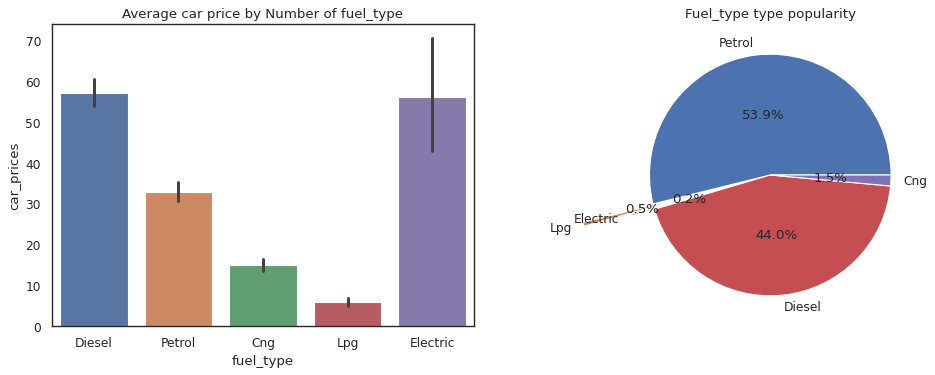

In [128]:
#fuel_type
plt.figure(figsize=(15, 5), dpi=80)
plt.subplot(1, 2, 1) 
ax = sns.barplot(x="fuel_type", y='car_prices', data=df2)
ax.set_title('Average car price by Number of fuel_type')

fuel = df2["fuel_type"].copy()
count = fuel.value_counts().sort_index(ascending=False)
print(count)
plt.subplot(1, 2, 2)
plt.pie(x=count,autopct='%.1f%%',labels = ["Petrol","Lpg","Electric","Diesel","Cng"],pctdistance=0.5, explode= [0,0.6,0.2,0,0])
plt.title('Fuel_type type popularity')

<AxesSubplot:title={'center':'Average car price by Year'}, xlabel='Age'>

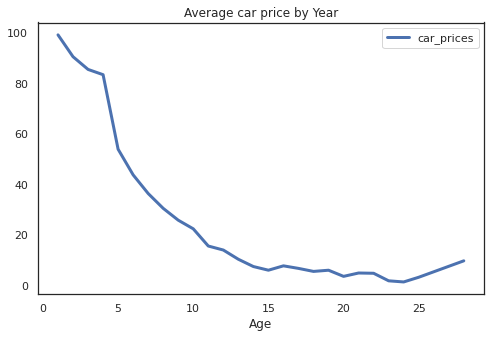

In [33]:
pv1=pd.pivot_table(df2, index=['Age'],values = ['car_prices'],aggfunc = 'mean') 
pv1.plot(kind='line',linewidth=3,figsize=(8,5),title='Average car price by Year')

Text(0.5, 1.0, 'Average car price by Number of engine_class')

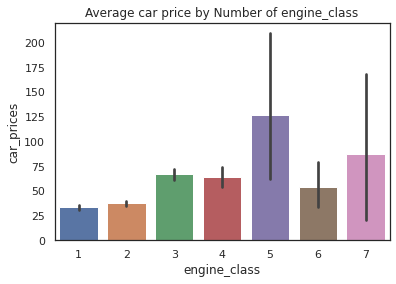

In [34]:
ax = sns.barplot(x="engine_class", y='car_prices', data=df2)
ax.set_title('Average car price by Number of engine_class')

In [35]:
# pv2=pd.pivot_table(df2, index=['Seats'],values = ['car_prices'],aggfunc = 'mean') 
# pv2.plot(kind='bar',figsize=(8,5),title='Average car price by Number of seats',edgecolor = 'black')

In [36]:
# pv2=pd.pivot_table(df2, index=['engine_class'],values = ['car_prices'],aggfunc = 'mean') 
# pv2.plot(kind='bar',figsize=(8,5),title='Average car price by Number of engine',edgecolor = 'black')

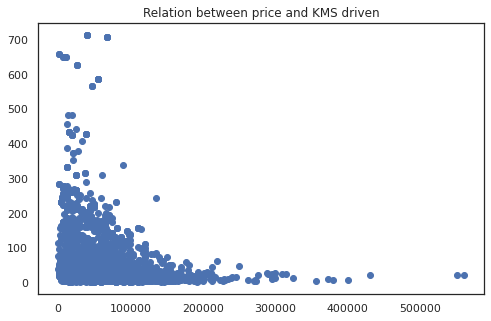

In [37]:
plt.figure(figsize=(8,5))
plt.title('Relation between price and KMS driven')
plt.scatter(df2.kms_driven,df2.car_prices,color="b")

<AxesSubplot:title={'center':'Average price by Fuel type'}, ylabel='transmission'>

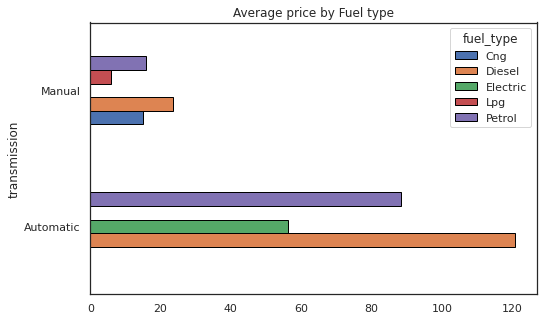

In [38]:
transm=pd.pivot_table(df2,index='transmission',values='car_prices',columns='fuel_type')
transm.plot(kind='barh',figsize=(8,5),edgecolor = 'black',title='Average price by Fuel type')

<AxesSubplot:title={'center':'Price Distribution'}, ylabel='Frequency'>

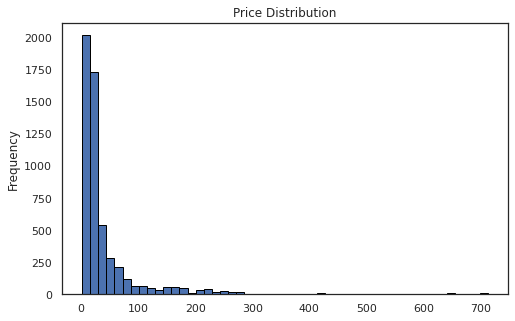

In [39]:
price=df['car_prices']
price.plot(kind='hist',figsize=(8,5),bins=50,edgecolor = 'black',title='Price Distribution')

Text(0.5, 1.0, 'Every 5 year price trend')

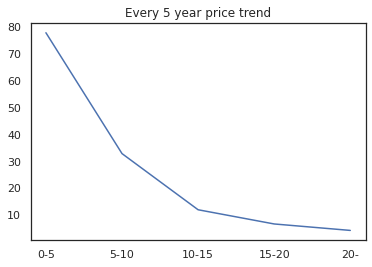

In [40]:
P1 = df[df['Age'] <= 5]['car_prices'].mean()
P2 = df[(df['Age']>5) & (df['Age']<=10)]['car_prices'].mean()
P3 = df[(df['Age']>10) & (df['Age']<=15)]['car_prices'].mean()
P4 = df[(df['Age']>15) & (df['Age']<=20)]['car_prices'].mean()
P5 = df[df['Age']>20]['car_prices'].mean()
Plist = [P1,P2,P3,P4,P5]
Rlist = ["0-5","5-10","10-15","15-20","20-"]
pv2=sns.lineplot(x=Rlist, y=Plist)
pv2.set_title('Every 5 year price trend')

Text(0.5, 1.0, 'Every 5 year price trend')

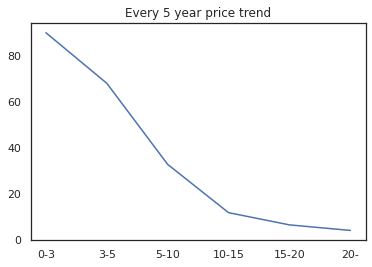

In [41]:
P1 = df[df['Age'] <= 3]['car_prices'].mean()
P2 = df[(df['Age']>3) & (df['Age']<=5)]['car_prices'].mean()
P3 = df[(df['Age']>5) & (df['Age']<=10)]['car_prices'].mean()
P4 = df[(df['Age']>10) & (df['Age']<=15)]['car_prices'].mean()
P5 = df[(df['Age']>15) & (df['Age']<=20)]['car_prices'].mean()
P6 = df[df['Age']>20]['car_prices'].mean()
Plist = [P1,P2,P3,P4,P5,P6]
Rlist = ["0-3","3-5","5-10","10-15","15-20","20-"]
pv2=sns.lineplot(x=Rlist, y=Plist)
pv2.set_title('Every 5 year price trend')

<AxesSubplot:title={'center':'The Most expensive 5 cars'}, ylabel='car_name'>

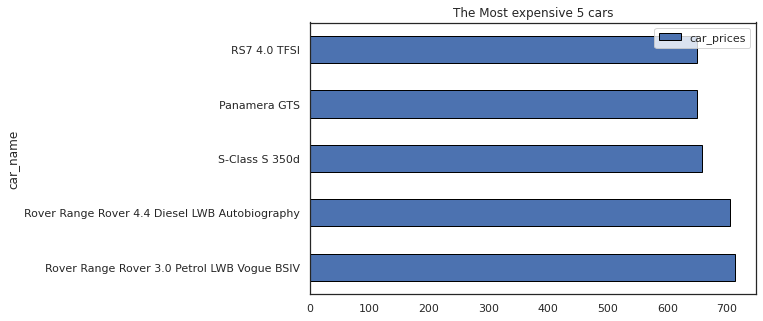

In [42]:
top5=pd.pivot_table(df2,index='car_name',values='car_prices').sort_values(by='car_prices',ascending=False)
top5=top5.head(5)
top5.plot(kind='barh',figsize=(8,5),edgecolor = 'black',title='The Most expensive 5 cars')

**In those old cars, I think it might has some cars are worth collecting not for buying to use.  
I find "Tiago XTA AMT" is much expensive than others**


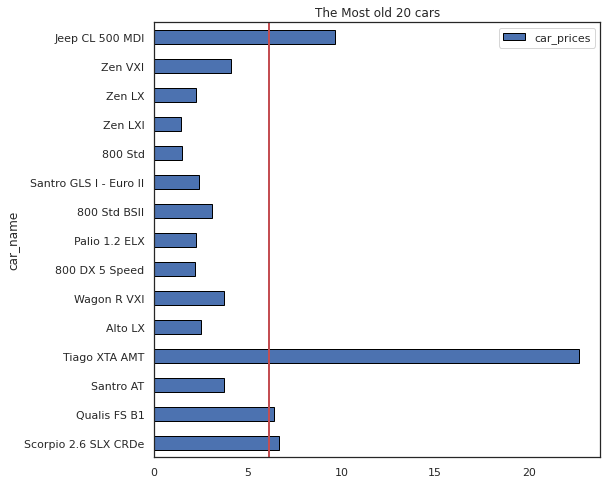

In [43]:
df3 = df2.copy()
df3.sort_values(by=['Age'],inplace = True)
old5=df3.iloc[-20:,:]

top5=pd.pivot_table(old5,index='car_name',values='car_prices',sort=False)
top5.plot(kind='barh',figsize=(8,8),edgecolor = 'black',title='The Most old 20 cars')

price = df2.copy().sort_values('car_prices')
plt.axvline(x = df2[df2['Age']>=15]['car_prices'].mean(),linewidth=2, color='r')

In [44]:
old5.sort_values("car_prices",ascending = False)

,Brand_lv,car_name,car_prices,multiply NT,kms_driven,fuel_type,transmission,ownership,Age,engine_class,Seats
4633,0,Tiago XTA AMT,22.69,10K,2640,Petrol,Automatic,1,21,2,5
480,0,Jeep CL 500 MDI,9.67,10K,100000,Diesel,Manual,1,28,1,6
906,0,Scorpio 2.6 SLX CRDe,6.69,10K,120000,Diesel,Manual,3,21,3,5
4498,0,Qualis FS B1,6.51,10K,120000,Diesel,Manual,3,22,2,5
2111,0,Qualis FS B1,6.32,10K,120000,Diesel,Manual,3,21,1,5
367,0,Zen VXI,4.09,10K,90000,Petrol,Manual,3,25,1,5
4486,0,Santro AT,3.72,10K,68000,Petrol,Automatic,2,21,2,5
4841,0,Wagon R VXI,3.72,10K,59726,Petrol,Manual,1,21,2,5
3076,0,800 Std BSII,3.11,10K,29000,Petrol,Manual,1,21,1,7
2595,0,Alto LX,2.96,10K,70000,Petrol,Manual,2,21,1,5


 **According to the information online,Tata was first launched Tiago XTA AMT in 2017.The data in this case might be wrong.**  
 **Compare the price of "Tata Tiago XTA AMT" to others manufactured in 2017 and Brand_lv also is 0,there price are closed.**  
 **I think we should modify the manufacture year into 2017.**

In [45]:
print(df[(df["manufacture"]==2017) & (df["Brand_lv"] == 0)]["car_prices"].mean())
df[df["car_name"]=="Tiago XTA AMT"]

25.49777559055118


,Unnamed: 0,Brand,Brand_lv,car_name,car_prices,multiply NT,kms_driven,fuel_type,transmission,ownership,manufacture,Age,engine,engine_class,Seats
4633,4633,Tata,0,Tiago XTA AMT,22.69,10K,2640,Petrol,Automatic,1,2002,21,1298,2,5


In [46]:
df2[df2["car_name"] == "Tiago XTA AMT"]["Age"] = df2[df2["car_name"] == "Tiago XTA AMT"]["Age"]-15
df2[df2["car_name"] == "Tiago XTA AMT"] = df2[df2["car_name"] == "Tiago XTA AMT"].replace(21,6)
df2[df2["car_name"] == "Tiago XTA AMT"]

,Brand_lv,car_name,car_prices,multiply NT,kms_driven,fuel_type,transmission,ownership,Age,engine_class,Seats
4633,0,Tiago XTA AMT,22.69,10K,2640,Petrol,Automatic,1,6,2,5


In [47]:
display(df3.tail(1))
display(df3.iloc[-10:-9])

,Brand_lv,car_name,car_prices,multiply NT,kms_driven,fuel_type,transmission,ownership,Age,engine_class,Seats
480,0,Jeep CL 500 MDI,9.67,10K,100000,Diesel,Manual,1,28,1,6


,Brand_lv,car_name,car_prices,multiply NT,kms_driven,fuel_type,transmission,ownership,Age,engine_class,Seats
4498,0,Qualis FS B1,6.51,10K,120000,Diesel,Manual,3,22,2,5


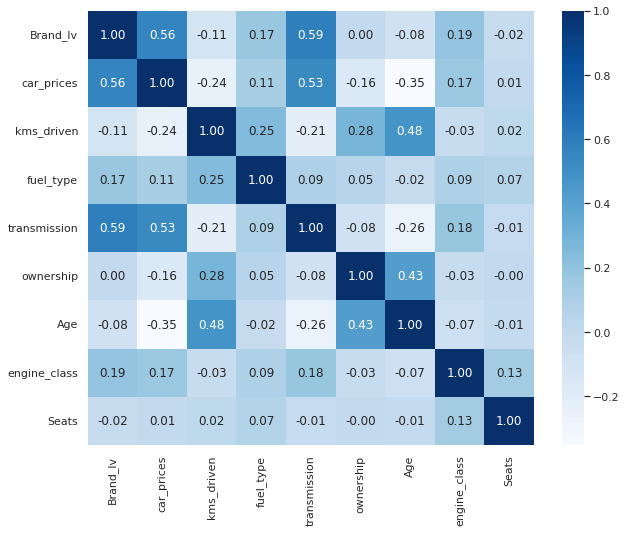

In [48]:
df_hm = df2.copy()
df_hm["fuel_type"] = df_hm["fuel_type"].map({"Petrol":0,"Diesel":1,"Cng":2,"Lpg":3,"Electric":4})
df_hm["transmission"] = df_hm["transmission"].map({"Manual":0,"Automatic":1})

# Verify the heatmap of correlations 
plt.figure(figsize = (10, 8))
sns.heatmap(df_hm.corr(), cmap = 'Blues', annot = True, fmt = '.2f');

## Machine Learning

In [49]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5500 entries, 0 to 5511
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Brand_lv      5500 non-null   int64  
 1   car_name      5500 non-null   object 
 2   car_prices    5500 non-null   float64
 3   multiply NT   5500 non-null   object 
 4   kms_driven    5500 non-null   int64  
 5   fuel_type     5500 non-null   object 
 6   transmission  5500 non-null   object 
 7   ownership     5500 non-null   int64  
 8   Age           5500 non-null   int64  
 9   engine_class  5500 non-null   int64  
 10  Seats         5500 non-null   int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 644.7+ KB


In [50]:
df_train= df2.copy()
df_train["fuel_type"] = df_train["fuel_type"].map({"Petrol":0,"Diesel":1,"Cng":2,"Lpg":3,"Electric":4})
df_train["transmission"] = df_train["transmission"].map({"Manual":0,"Automatic":1})

df_train.drop(["car_name","multiply NT"],axis=1,inplace=True)
df_train

,Brand_lv,car_prices,kms_driven,fuel_type,transmission,ownership,Age,engine_class,Seats
0,1,37.30,86226,1,0,1,6,3,5
1,0,47.72,13248,0,1,1,2,2,5
2,0,61.00,60343,0,1,1,7,4,5
3,0,28.90,26696,0,1,1,5,1,5
4,1,19.15,69414,0,0,1,7,1,5
...,...,...,...,...,...,...,...,...,...
5507,2,107.49,45000,1,1,1,5,4,7
5508,2,241.38,29000,0,1,2,8,3,5
5509,2,51.14,90000,1,1,2,10,4,5
5510,2,111.21,79000,1,1,3,8,4,6


In [51]:
df_X = df_train.copy().drop(["car_prices"],axis = 1)
df_y = df_train["car_prices"].copy()

In [52]:
# Split data to train and test: 

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y ,test_size=0.25, random_state=1)

In [53]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4125 entries, 3052 to 5168
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Brand_lv      4125 non-null   int64
 1   kms_driven    4125 non-null   int64
 2   fuel_type     4125 non-null   int64
 3   transmission  4125 non-null   int64
 4   ownership     4125 non-null   int64
 5   Age           4125 non-null   int64
 6   engine_class  4125 non-null   int64
 7   Seats         4125 non-null   int64
dtypes: int64(8)
memory usage: 290.0 KB


In [54]:
y_train

3052      7.44
111     115.30
3528      9.37
4254    162.72
2731      6.73
         ...  
909      21.01
5203     31.69
3990     21.57
235      29.38
5168     18.37
Name: car_prices, Length: 4125, dtype: float64

In [55]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score,GridSearchCV


Regression=[ ]
Regression.append(RandomForestRegressor())
Regression.append(DecisionTreeRegressor())
Regression.append(LinearRegression())

Regression

[RandomForestRegressor(), DecisionTreeRegressor(), LinearRegression()]

In [56]:
from sklearn.utils.multiclass import type_of_target
type_of_target(y_train)

'continuous'

In [57]:
cv_results=[]

LR_model = LinearRegression(n_jobs=-1)
cv_results.append(cross_val_score(LR_model,X_train,y_train,cv=10,n_jobs=-1))


randomForestModel = RandomForestRegressor(n_estimators=100, criterion ='friedman_mse')
cv_results.append(cross_val_score(randomForestModel,X_train,y_train,cv=10,n_jobs=-1))


decisionTreeModel = DecisionTreeRegressor(max_depth=4, splitter='best', random_state=42)
cv_results.append(cross_val_score(decisionTreeModel,X_train,y_train,cv=10,n_jobs=-1))

 
cv_results

[array([0.5394516 , 0.41487987, 0.39776766, 0.50158566, 0.42269799,
        0.39561387, 0.44830671, 0.46311598, 0.41100744, 0.4880446 ]),
 array([0.79754587, 0.87307829, 0.85107154, 0.87755377, 0.84472276,
        0.88214629, 0.87798449, 0.83654296, 0.7783039 , 0.78237048]),
 array([0.67327155, 0.71271987, 0.67647237, 0.67946329, 0.57162285,
        0.57606692, 0.66082801, 0.58281966, 0.54949619, 0.82526434])]

In [58]:
cv_means=[]
cv_std=[]
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cvResDf=pd.DataFrame({'cv_mean': cv_means,
                          'cv_std' : cv_std,
                          'algorithm':['LinearRegression','RandomForestRegressor','DecisionTreeRegressor']})
cvResDf

,cv_mean,cv_std,algorithm
0,0.448247,0.046303,LinearRegression
1,0.840132,0.038484,RandomForestRegressor
2,0.650803,0.079433,DecisionTreeRegressor


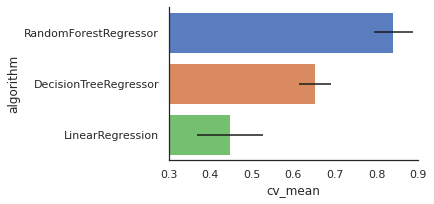

In [59]:
#Model Selection
cvResFacet=sns. FacetGrid(cvResDf . sort_values(by='cv_mean', ascending=False),sharex=False,
                          sharey=False, aspect=2)
cvResFacet.map(sns.barplot, 'cv_mean', 'algorithm' ,**{'xerr' :cv_std},
               palette='muted')
cvResFacet.set(xlim=(0.3,0.9))
cvResFacet.add_legend()

In [60]:
rFModel = RandomForestRegressor(n_estimators=100, criterion = 'friedman_mse')
# 使用訓練資料訓練模型
rFModel.fit(X_train,y_train)

RandomForestRegressor(criterion='friedman_mse')

In [61]:
score = rFModel.score(X_train,y_train)
score

0.9755555897942753

In [62]:
from sklearn.metrics import mean_squared_error #均方误差
from sklearn.metrics import mean_absolute_error #平方绝对课差
from sklearn.metrics import r2_score#R square

y_pred = rFModel.predict(X_test)
rscore=r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("rscore:",rscore,"mse:",mse,"mae:",mae)

rscore: 0.7259119142260613 mse: 1352.2251885799928 mae: 13.412009674445752


In [63]:
import statsmodels.api as sm

In [64]:
# # Apply linear regression by statsmodel 
model = sm.OLS(y_train, X_train)
results = model.fit()

In [65]:
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:             car_prices   R-squared (uncentered):                   0.585
Model:                            OLS   Adj. R-squared (uncentered):              0.584
Method:                 Least Squares   F-statistic:                              724.2
Date:                Fri, 03 Mar 2023   Prob (F-statistic):                        0.00
Time:                        12:54:13   Log-Likelihood:                         -22422.
No. Observations:                4125   AIC:                                  4.486e+04
Df Residuals:                    4117   BIC:                                  4.491e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

### Prediction Analysis

In [66]:
df2['Price_prediction']=rFModel.predict(df_X)

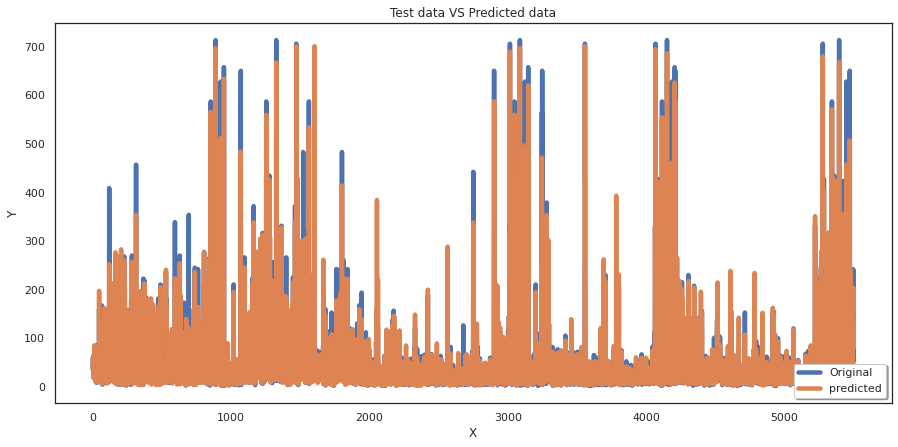

In [67]:
prd=df2['Price_prediction']
x_ax = range(len(df_y))
plt.figure(figsize=(15,7))
plt.plot(x_ax, df_y,linewidth = '4.5', label="Original")
plt.plot(x_ax, prd, linewidth = '4.5', label="predicted")
plt.title("Test data VS Predicted data")
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc='lower right',fancybox=True, shadow=True)
plt.show() 

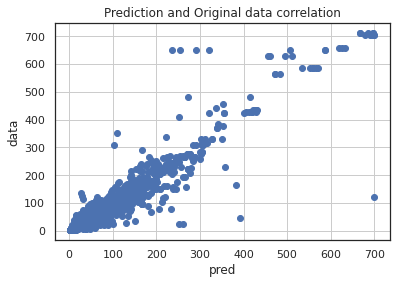

In [68]:
plt.scatter(df2['Price_prediction'],df2['car_prices'],color="b",)
plt.title('Prediction and Original data correlation')
plt.xlabel("pred")
plt.ylabel("data")
plt.grid()

In [69]:
df2["Deviation"] = (df2['Price_prediction']) - ( df2['car_prices'])
df2

,Brand_lv,car_name,car_prices,multiply NT,kms_driven,fuel_type,transmission,ownership,Age,engine_class,Seats,Price_prediction,Deviation
0,1,Compass 2.0 Longitude Option BSIV,37.30,10K,86226,Diesel,Manual,1,6,3,5,39.862100,2.562100
1,0,Duster RXZ Turbo CVT,47.72,10K,13248,Petrol,Automatic,1,2,2,5,49.656100,1.936100
2,0,Camry 2.5 G,61.00,10K,60343,Petrol,Automatic,1,7,4,5,49.540500,-11.459500
3,0,Jazz VX CVT,28.90,10K,26696,Petrol,Automatic,1,5,1,5,25.208800,-3.691200
4,1,Polo 1.2 MPI Highline,19.15,10K,69414,Petrol,Manual,1,7,1,5,18.000508,-1.149492
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5507,2,X1 sDrive 20d xLine,107.49,10K,45000,Diesel,Automatic,1,5,4,7,164.209300,56.719300
5508,2,M Series M4 Coupe,241.38,10K,29000,Petrol,Automatic,2,8,3,5,203.818500,-37.561500
5509,2,XF 2.2 Litre Luxury,51.14,10K,90000,Diesel,Automatic,2,10,4,5,78.955700,27.815700
5510,2,7 Series 730Ld,111.21,10K,79000,Diesel,Automatic,3,8,4,6,109.772900,-1.437100


In [70]:
df2[ (abs(df2["Deviation"])>= 50)].sort_values("Deviation",ascending = False)

,Brand_lv,car_name,car_prices,multiply NT,kms_driven,fuel_type,transmission,ownership,Age,engine_class,Seats,Price_prediction,Deviation
1609,2,X1 sDrive 20d xLine,120.88,10K,65000,Diesel,Automatic,1,4,2,5,700.098000,579.218000
3793,0,Seltos HTK Plus AT D,45.97,10K,27371,Diesel,Automatic,1,4,2,5,392.555500,346.585500
1672,0,TUV 300 T10 AMT,23.25,10K,56276,Diesel,Automatic,2,5,2,5,260.949800,237.699800
3253,0,Tigor EV XM,23.47,10K,25882,Electric,Automatic,1,4,2,5,251.576300,228.106300
2063,2,3 Series GT Luxury Line,163.65,10K,14000,Diesel,Automatic,1,3,2,5,383.783619,220.133619
...,...,...,...,...,...,...,...,...,...,...,...,...,...
697,0,Land Cruiser VX,353.33,10K,21000,Diesel,Automatic,1,5,1,7,110.722100,-242.607900
4213,2,RS7 4.0 TFSI,649.62,10K,7100,Petrol,Automatic,1,2,5,5,321.211900,-328.408100
1074,2,Panamera GTS,649.62,10K,10000,Petrol,Automatic,1,4,3,5,291.908200,-357.711800
3258,2,Panamera GTS,649.62,10K,10000,Petrol,Automatic,1,4,1,5,253.307000,-396.313000


In [71]:
df2[ (abs(df2["Deviation"])>= 50)]["engine_class"].value_counts().sort_index(ascending = True)

1    23
2    26
3    34
4    12
5     3
6     3
Name: engine_class, dtype: int64

In [72]:
(df2[ (abs(df2["Deviation"])>= 50)]["engine_class"].value_counts().sort_index(ascending = True)/df2["engine_class"].value_counts() )*100

1     1.072261
2     1.329243
3     3.563941
4     3.069054
5    13.043478
6    11.538462
7          NaN
Name: engine_class, dtype: float64

In [73]:
df2[ (abs(df2["Deviation"])>= 50)]["Brand_lv"].value_counts().sort_index(ascending = True)

0    26
1     6
2    68
3     1
Name: Brand_lv, dtype: int64

In [74]:
df2[ (abs(df2["Deviation"])>= 50)]["Brand_lv"].value_counts().sort_index(ascending = True)/(df2["Brand_lv"].value_counts())*100

0     0.601017
1     1.595745
2     8.585859
3    16.666667
Name: Brand_lv, dtype: float64

### Create own data

In [75]:
import requests
from  bs4  import BeautifulSoup
#from selenium import webdriver
#from selenium.webdriver.support.ui import Select
import requests
import string
import pandas as pd

column = ['車型','出廠時間','行駛里程','燃料排氣','顏色','變速系統','傳動系統','乘坐人數','所在地','售價']
detail = []
df_tw =  pd.DataFrame(data = detail, columns = column )

def getcardetails(title,link,c):
    url = link
    res = requests.get(url)
    soup = BeautifulSoup(res.text, "html.parser")
    content = soup.find_all("div",class_= 'text-bold',limit = 8)
    price = soup.find_all("span",class_= 'abc-article__price__num text-2xl')
    count = 0
    for i,n in enumerate (content[0:9]):
        #print(n)
        s = (n.text.strip().replace(" ",""))
        df_tw.loc[c,column[i+1]] = s
        df_tw.loc[c,'售價'] = price[0].text.strip().replace(" ","")
        if i == 0 :
            df_tw.loc[c,column[i]] = title
        else:
            continue

        #print(s)
    return df_tw


url ='https://autos.yahoo.com.tw/used-cars/'

res = requests.get(url)
soup = BeautifulSoup(res.text, "html.parser")
limit = 15
count = 0
content = soup.find_all("div",class_= 'related-content',limit = limit)
#print(content[0].find_all('a')[1].get('title'))


for n in range(limit):
    for r in range(5):
        link = content[n].find_all('a')[r].get('href')
        title = content[n].find_all('a')[r].get('title')
        getcardetails(title,link,count)
        count +=1 

df_tw

,車型,出廠時間,行駛里程,燃料排氣,顏色,變速系統,傳動系統,乘坐人數,所在地,售價
0,2012 M-Benz 賓士 C-Class Sedan,2012年03月,"166,718公里",汽油/1.8L,黑色,手自排,後輪驅動,5人,高雄市,68.8萬
1,2017 M-Benz 賓士 C-Class Estate,2017年11月,"53,000公里",汽油/3.0L,白色,手自排,四輪驅動,5人,新北市,248萬
2,2008 M-Benz 賓士 C-Class Sedan,2008年05月,"100,000公里",汽油/6.0L,黑色,手自排,後輪驅動,5人,彰化縣,53.8萬
3,2016 M-Benz 賓士 C-Class Coupe,2016年05月,"56,500公里",汽油/2.0L,白色,手自排,後輪驅動,4人,台南市,158萬
4,2014 M-Benz 賓士 C-Class Sedan,2014年09月,"87,165公里",汽油/3.0L,白色,手自排,後輪驅動,5人,新北市,139萬
...,...,...,...,...,...,...,...,...,...,...
70,2022 Suzuki 鈴木 Jimny,2022年12月,28公里,汽油/1.5L,其他,自排,四輪驅動,4人,高雄市,99.8萬
71,2022 Suzuki 鈴木 Jimny,2022年12月,27公里,汽油/1.5L,灰色,自排,四輪驅動,4人,台中市,98萬
72,2022 Suzuki 鈴木 Jimny,2022年12月,10公里,汽油/1.5L,綠色,自排,四輪驅動,4人,台中市,98.8萬
73,2022 Suzuki 鈴木 Jimny,2022年12月,43公里,汽油/1.5L,綠色,自排,四輪驅動,4人,彰化縣,95.9萬


In [76]:
df_tw.to_csv(f"台灣二手汽車資料.csv")

### Compare the official data and our own data web crawl from Yahoo cars

In [77]:
display(df_tw.head())
display(X_test.head())

,車型,出廠時間,行駛里程,燃料排氣,顏色,變速系統,傳動系統,乘坐人數,所在地,售價
0,2012 M-Benz 賓士 C-Class Sedan,2012年03月,"166,718公里",汽油/1.8L,黑色,手自排,後輪驅動,5人,高雄市,68.8萬
1,2017 M-Benz 賓士 C-Class Estate,2017年11月,"53,000公里",汽油/3.0L,白色,手自排,四輪驅動,5人,新北市,248萬
2,2008 M-Benz 賓士 C-Class Sedan,2008年05月,"100,000公里",汽油/6.0L,黑色,手自排,後輪驅動,5人,彰化縣,53.8萬
3,2016 M-Benz 賓士 C-Class Coupe,2016年05月,"56,500公里",汽油/2.0L,白色,手自排,後輪驅動,4人,台南市,158萬
4,2014 M-Benz 賓士 C-Class Sedan,2014年09月,"87,165公里",汽油/3.0L,白色,手自排,後輪驅動,5人,新北市,139萬


,Brand_lv,kms_driven,fuel_type,transmission,ownership,Age,engine_class,Seats
4420,0,140000,1,0,2,11,1,5
2266,0,142366,1,0,1,11,1,5
3694,0,70000,0,0,2,18,3,5
4716,0,27924,1,0,1,3,3,5
5441,0,79718,1,0,1,14,2,5


### Columns in two data both have --> 7 features 
### 'Brand_lv', 'kms_driven', 'fuel_type', 'transmission', 'Age', 'engine_class', 'Seats'

## Data Preprocessing 

In [78]:
df_tw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62 entries, 0 to 74
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   車型      62 non-null     object
 1   出廠時間    62 non-null     object
 2   行駛里程    62 non-null     object
 3   燃料排氣    62 non-null     object
 4   顏色      62 non-null     object
 5   變速系統    62 non-null     object
 6   傳動系統    62 non-null     object
 7   乘坐人數    62 non-null     object
 8   所在地     62 non-null     object
 9   售價      62 non-null     object
dtypes: object(10)
memory usage: 7.4+ KB


In [79]:
df_tw.describe()

,車型,出廠時間,行駛里程,燃料排氣,顏色,變速系統,傳動系統,乘坐人數,所在地,售價
count,62,62,62,62,62,62,62,62,62,62
unique,44,41,49,11,9,4,3,3,10,45
top,2022 Suzuki 鈴木 Jimny,2022年12月,"87,165公里",汽油/2.0L,白色,手自排,前輪驅動,5人,新北市,139萬
freq,5,5,4,14,25,39,27,47,13,4


In [80]:
df_tw.duplicated()

0     False
1     False
2     False
3     False
4     False
      ...  
70    False
71    False
72    False
73    False
74    False
Length: 62, dtype: bool

In [81]:
X_test.columns

Index(['Brand_lv', 'kms_driven', 'fuel_type', 'transmission', 'ownership',
       'Age', 'engine_class', 'Seats'],
      dtype='object')

In [82]:
df_twNew = pd.DataFrame(data = [],columns = ['Brand_lv', 'kms_driven', 'fuel_type', 'transmission',
       'Age', 'engine_class', 'Seats'])
df_twNew

,Brand_lv,kms_driven,fuel_type,transmission,Age,engine_class,Seats


In [83]:
df_twNew["kms_driven"] = df_tw["行駛里程"].str.strip("公里")
df_twNew["kms_driven"] = df_twNew["kms_driven"].str.replace(",","")

In [84]:
df_twNew['kms_driven'] = df_tw["行駛里程"].str.strip("公里").str.replace(",","")
df_twNew

,Brand_lv,kms_driven,fuel_type,transmission,Age,engine_class,Seats
0,NaN,166718,NaN,NaN,NaN,NaN,NaN
1,NaN,53000,NaN,NaN,NaN,NaN,NaN
2,NaN,100000,NaN,NaN,NaN,NaN,NaN
3,NaN,56500,NaN,NaN,NaN,NaN,NaN
4,NaN,87165,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
70,NaN,28,NaN,NaN,NaN,NaN,NaN
71,NaN,27,NaN,NaN,NaN,NaN,NaN
72,NaN,10,NaN,NaN,NaN,NaN,NaN
73,NaN,43,NaN,NaN,NaN,NaN,NaN


In [85]:
fuel = df_tw["燃料排氣"].str.split("/")
df_twNew['fuel_type'] = [i[0] for i in fuel]
df_twNew['engine_class'] = [i[1] for i in fuel]
df_twNew

,Brand_lv,kms_driven,fuel_type,transmission,Age,engine_class,Seats
0,NaN,166718,汽油,NaN,NaN,1.8L,NaN
1,NaN,53000,汽油,NaN,NaN,3.0L,NaN
2,NaN,100000,汽油,NaN,NaN,6.0L,NaN
3,NaN,56500,汽油,NaN,NaN,2.0L,NaN
4,NaN,87165,汽油,NaN,NaN,3.0L,NaN
...,...,...,...,...,...,...,...
70,NaN,28,汽油,NaN,NaN,1.5L,NaN
71,NaN,27,汽油,NaN,NaN,1.5L,NaN
72,NaN,10,汽油,NaN,NaN,1.5L,NaN
73,NaN,43,汽油,NaN,NaN,1.5L,NaN


In [86]:
df_twNew['Seats'] = df_tw["乘坐人數"].str.strip("人")
df_twNew

,Brand_lv,kms_driven,fuel_type,transmission,Age,engine_class,Seats
0,NaN,166718,汽油,NaN,NaN,1.8L,5
1,NaN,53000,汽油,NaN,NaN,3.0L,5
2,NaN,100000,汽油,NaN,NaN,6.0L,5
3,NaN,56500,汽油,NaN,NaN,2.0L,4
4,NaN,87165,汽油,NaN,NaN,3.0L,5
...,...,...,...,...,...,...,...
70,NaN,28,汽油,NaN,NaN,1.5L,4
71,NaN,27,汽油,NaN,NaN,1.5L,4
72,NaN,10,汽油,NaN,NaN,1.5L,4
73,NaN,43,汽油,NaN,NaN,1.5L,4


In [87]:
df_twNew['Age'] = [n[0:4] for n in df_tw["出廠時間"]]
df_twNew['Age'] = df_twNew['Age'].astype("int")
df_twNew['Age'] = 2023 - df_twNew['Age']
df_twNew

,Brand_lv,kms_driven,fuel_type,transmission,Age,engine_class,Seats
0,NaN,166718,汽油,NaN,11,1.8L,5
1,NaN,53000,汽油,NaN,6,3.0L,5
2,NaN,100000,汽油,NaN,15,6.0L,5
3,NaN,56500,汽油,NaN,7,2.0L,4
4,NaN,87165,汽油,NaN,9,3.0L,5
...,...,...,...,...,...,...,...
70,NaN,28,汽油,NaN,1,1.5L,4
71,NaN,27,汽油,NaN,1,1.5L,4
72,NaN,10,汽油,NaN,1,1.5L,4
73,NaN,43,汽油,NaN,1,1.5L,4


In [88]:
df_twNew['transmission'] = df_tw["變速系統"]
df_twNew

,Brand_lv,kms_driven,fuel_type,transmission,Age,engine_class,Seats
0,NaN,166718,汽油,手自排,11,1.8L,5
1,NaN,53000,汽油,手自排,6,3.0L,5
2,NaN,100000,汽油,手自排,15,6.0L,5
3,NaN,56500,汽油,手自排,7,2.0L,4
4,NaN,87165,汽油,手自排,9,3.0L,5
...,...,...,...,...,...,...,...
70,NaN,28,汽油,自排,1,1.5L,4
71,NaN,27,汽油,自排,1,1.5L,4
72,NaN,10,汽油,自排,1,1.5L,4
73,NaN,43,汽油,自排,1,1.5L,4


In [89]:
df_tw["車型"].str.split(" ",3)

0      [2012, M-Benz, 賓士, C-Class Sedan]
1     [2017, M-Benz, 賓士, C-Class Estate]
2      [2008, M-Benz, 賓士, C-Class Sedan]
3      [2016, M-Benz, 賓士, C-Class Coupe]
4      [2014, M-Benz, 賓士, C-Class Sedan]
                     ...                
70             [2022, Suzuki, 鈴木, Jimny]
71             [2022, Suzuki, 鈴木, Jimny]
72             [2022, Suzuki, 鈴木, Jimny]
73             [2022, Suzuki, 鈴木, Jimny]
74             [2022, Suzuki, 鈴木, Jimny]
Name: 車型, Length: 62, dtype: object

In [90]:
df_twNew.insert(0,"Brand","")
df_twNew.insert(2,"car_name","")
car = df_tw["車型"].str.split(" ",3)
df_twNew["Brand"] = [i[1] for i in car]
df_twNew["car_name"] = [i[3] for i in car]
df_twNew

,Brand,Brand_lv,car_name,kms_driven,fuel_type,transmission,Age,engine_class,Seats
0,M-Benz,NaN,C-Class Sedan,166718,汽油,手自排,11,1.8L,5
1,M-Benz,NaN,C-Class Estate,53000,汽油,手自排,6,3.0L,5
2,M-Benz,NaN,C-Class Sedan,100000,汽油,手自排,15,6.0L,5
3,M-Benz,NaN,C-Class Coupe,56500,汽油,手自排,7,2.0L,4
4,M-Benz,NaN,C-Class Sedan,87165,汽油,手自排,9,3.0L,5
...,...,...,...,...,...,...,...,...,...
70,Suzuki,NaN,Jimny,28,汽油,自排,1,1.5L,4
71,Suzuki,NaN,Jimny,27,汽油,自排,1,1.5L,4
72,Suzuki,NaN,Jimny,10,汽油,自排,1,1.5L,4
73,Suzuki,NaN,Jimny,43,汽油,自排,1,1.5L,4


In [91]:
df_twNew["Brand"].value_counts()

M-Benz     12
Toyota      7
BMW         6
Mini        5
Mazda       5
Honda       5
Nissan      5
Land        5
Suzuki      5
Porsche     4
Ford        3
Name: Brand, dtype: int64

In [92]:
df_twNew["Brand"] = df_twNew["Brand"].replace("M-Benz","Mercedes-Benz")
df_twNew["Brand"].value_counts()

Mercedes-Benz    12
Toyota            7
BMW               6
Mini              5
Mazda             5
Honda             5
Nissan            5
Land              5
Suzuki            5
Porsche           4
Ford              3
Name: Brand, dtype: int64

In [93]:
df_twNew.reset_index(drop=True, inplace=True)
car_brand = {'LV1':["Toyota","Nissan","Mitsubishi","Ford","Hyundai","Isuzu","Honda","Datsun","Fiat","Kia","MG","Mahindra","Maruti","Premier","Tata","Renault","Force","Mazda","Suzuki"],
             'LV2':["Jeep","Lexus","Mini","Skoda","Volkswagen","Volvo"],
             'LV3':["Audi","BMW","Chevrolet","Jaguar","Land","Mercedes-Benz","Porsche"],
             'LV4':["Bentley","Maserati"]}

for i,brand in enumerate (df_twNew["Brand"]):
    if brand in car_brand['LV1']:
        df_twNew["Brand_lv"][i] = 0
    elif brand in car_brand['LV2']:
        df_twNew["Brand_lv"][i] = 1
    elif brand in car_brand['LV3']:
        df_twNew["Brand_lv"][i] = 2
    elif brand in car_brand['LV4']:
        df_twNew["Brand_lv"][i] = 3
    else:
        print(brand)
df_twNew

,Brand,Brand_lv,car_name,kms_driven,fuel_type,transmission,Age,engine_class,Seats
0,Mercedes-Benz,2,C-Class Sedan,166718,汽油,手自排,11,1.8L,5
1,Mercedes-Benz,2,C-Class Estate,53000,汽油,手自排,6,3.0L,5
2,Mercedes-Benz,2,C-Class Sedan,100000,汽油,手自排,15,6.0L,5
3,Mercedes-Benz,2,C-Class Coupe,56500,汽油,手自排,7,2.0L,4
4,Mercedes-Benz,2,C-Class Sedan,87165,汽油,手自排,9,3.0L,5
...,...,...,...,...,...,...,...,...,...
57,Suzuki,0,Jimny,28,汽油,自排,1,1.5L,4
58,Suzuki,0,Jimny,27,汽油,自排,1,1.5L,4
59,Suzuki,0,Jimny,10,汽油,自排,1,1.5L,4
60,Suzuki,0,Jimny,43,汽油,自排,1,1.5L,4


In [94]:
print(df_twNew["fuel_type"].value_counts())
print("________________________________________")
print(df_twNew["transmission"].value_counts())
print("________________________________________")
print(df_twNew["engine_class"].value_counts())

汽油        59
柴油         2
48V輕油電     1
Name: fuel_type, dtype: int64
________________________________________
手自排        39
CVT無段變速    11
自排          8
自手排         4
Name: transmission, dtype: int64
________________________________________
2.0L    17
3.0L    13
1.5L    13
1.8L     7
1.6L     6
6.0L     2
2.3L     2
2.4L     1
2.5L     1
Name: engine_class, dtype: int64


In [95]:
df_twNew["fuel_type"] = df_twNew["fuel_type"].map({"汽油":0,"柴油":1,"48V輕油電":4})
df_twNew["transmission"] = df_twNew["transmission"].map({"自手排":0,"CVT無段變速":1,"手自排":1,"自排":1})
df_twNew

,Brand,Brand_lv,car_name,kms_driven,fuel_type,transmission,Age,engine_class,Seats
0,Mercedes-Benz,2,C-Class Sedan,166718,0,1,11,1.8L,5
1,Mercedes-Benz,2,C-Class Estate,53000,0,1,6,3.0L,5
2,Mercedes-Benz,2,C-Class Sedan,100000,0,1,15,6.0L,5
3,Mercedes-Benz,2,C-Class Coupe,56500,0,1,7,2.0L,4
4,Mercedes-Benz,2,C-Class Sedan,87165,0,1,9,3.0L,5
...,...,...,...,...,...,...,...,...,...
57,Suzuki,0,Jimny,28,0,1,1,1.5L,4
58,Suzuki,0,Jimny,27,0,1,1,1.5L,4
59,Suzuki,0,Jimny,10,0,1,1,1.5L,4
60,Suzuki,0,Jimny,43,0,1,1,1.5L,4


In [96]:
(df_twNew["fuel_type"].value_counts())

0    59
1     2
4     1
Name: fuel_type, dtype: int64

In [97]:
df_twNew["engine_class"] = df_twNew["engine_class"].str.strip('L').astype('float')
df_twNew["engine_class"] = df_twNew["engine_class"]*1000
df_twNew["engine_class"]

0     1800.0
1     3000.0
2     6000.0
3     2000.0
4     3000.0
       ...  
57    1500.0
58    1500.0
59    1500.0
60    1500.0
61    1500.0
Name: engine_class, Length: 62, dtype: float64

In [98]:
for i,size in enumerate (df_twNew["engine_class"]):
    if size == 0:
        df_twNew["engine_class"][i] = 0
    elif size <=1200:
        df_twNew["engine_class"][i] = 1
    elif 1201<= size <=1800:
        df_twNew["engine_class"][i] = 2
    elif 1801<= size <=2400:
        df_twNew["engine_class"][i] = 3
    elif 2401<= size <=3000:
        df_twNew["engine_class"][i] = 4
    elif 3001<= size <=4200:
        df_twNew["engine_class"][i] = 5
    elif 4201<= size <=5400:
        df_twNew["engine_class"][i] = 6
    elif 5401<= size <=6600:
        df_twNew["engine_class"][i] = 7
df_twNew.sample(5)

,Brand,Brand_lv,car_name,kms_driven,fuel_type,transmission,Age,engine_class,Seats
42,Land,2,Range Rover Evoque,10000,4,1,2,3.0,5
57,Suzuki,0,Jimny,28,0,1,1,2.0,4
7,Mercedes-Benz,2,C-Class Sedan,87165,0,1,9,4.0,5
2,Mercedes-Benz,2,C-Class Sedan,100000,0,1,15,7.0,5
48,Mercedes-Benz,2,C-Class Estate,53000,0,1,6,4.0,5


In [99]:
df_twNew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Brand         62 non-null     object 
 1   Brand_lv      62 non-null     object 
 2   car_name      62 non-null     object 
 3   kms_driven    62 non-null     object 
 4   fuel_type     62 non-null     int64  
 5   transmission  62 non-null     int64  
 6   Age           62 non-null     int64  
 7   engine_class  62 non-null     float64
 8   Seats         62 non-null     object 
dtypes: float64(1), int64(3), object(5)
memory usage: 4.5+ KB


In [100]:
def changetype(target):
  return target.astype('int')

df_twNew['Brand_lv'] = changetype(df_twNew['Brand_lv'])
df_twNew['kms_driven'] = changetype(df_twNew['kms_driven'])
df_twNew['engine_class'] = changetype(df_twNew['engine_class'])
df_twNew['Seats'] = changetype(df_twNew['Seats'])

df_twNew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Brand         62 non-null     object
 1   Brand_lv      62 non-null     int64 
 2   car_name      62 non-null     object
 3   kms_driven    62 non-null     int64 
 4   fuel_type     62 non-null     int64 
 5   transmission  62 non-null     int64 
 6   Age           62 non-null     int64 
 7   engine_class  62 non-null     int64 
 8   Seats         62 non-null     int64 
dtypes: int64(7), object(2)
memory usage: 4.5+ KB


In [101]:
df_twFinal = df_twNew.copy().drop(columns = ["Brand","car_name"])
df_twFinal

,Brand_lv,kms_driven,fuel_type,transmission,Age,engine_class,Seats
0,2,166718,0,1,11,2,5
1,2,53000,0,1,6,4,5
2,2,100000,0,1,15,7,5
3,2,56500,0,1,7,3,4
4,2,87165,0,1,9,4,5
...,...,...,...,...,...,...,...
57,0,28,0,1,1,2,4
58,0,27,0,1,1,2,4
59,0,10,0,1,1,2,4
60,0,43,0,1,1,2,4


### Retrain the model

In [102]:
display(df_train.head())
display(df_twFinal.head())

,Brand_lv,car_prices,kms_driven,fuel_type,transmission,ownership,Age,engine_class,Seats
0,1,37.30,86226,1,0,1,6,3,5
1,0,47.72,13248,0,1,1,2,2,5
2,0,61.00,60343,0,1,1,7,4,5
3,0,28.90,26696,0,1,1,5,1,5
4,1,19.15,69414,0,0,1,7,1,5


,Brand_lv,kms_driven,fuel_type,transmission,Age,engine_class,Seats
0,2,166718,0,1,11,2,5
1,2,53000,0,1,6,4,5
2,2,100000,0,1,15,7,5
3,2,56500,0,1,7,3,4
4,2,87165,0,1,9,4,5


In [103]:
df_X = df_train.copy().drop(columns = ["car_prices","ownership"],axis = 1)
df_y = df_train["car_prices"].copy()

display(df_X.head())
display(df_twFinal.head())

,Brand_lv,kms_driven,fuel_type,transmission,Age,engine_class,Seats
0,1,86226,1,0,6,3,5
1,0,13248,0,1,2,2,5
2,0,60343,0,1,7,4,5
3,0,26696,0,1,5,1,5
4,1,69414,0,0,7,1,5


,Brand_lv,kms_driven,fuel_type,transmission,Age,engine_class,Seats
0,2,166718,0,1,11,2,5
1,2,53000,0,1,6,4,5
2,2,100000,0,1,15,7,5
3,2,56500,0,1,7,3,4
4,2,87165,0,1,9,4,5


In [104]:
df_tw["售價"].str.strip("萬")

0     68.8
1      248
2     53.8
3      158
4      139
      ... 
70    99.8
71      98
72    98.8
73    95.9
74    98.8
Name: 售價, Length: 62, dtype: object

In [105]:
tw_price = df_tw["售價"].str.strip("萬")
tw_price = tw_price.astype("float")
tw_price

0      68.8
1     248.0
2      53.8
3     158.0
4     139.0
      ...  
70     99.8
71     98.0
72     98.8
73     95.9
74     98.8
Name: 售價, Length: 62, dtype: float64

In [106]:
# Split data to train and test: 

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y ,test_size=0.25, random_state=1)

In [107]:
rFModel = RandomForestRegressor(n_estimators=100, criterion = 'friedman_mse')
# 使用訓練資料訓練模型
rFModel.fit(X_train,y_train)

RandomForestRegressor(criterion='friedman_mse')

In [108]:
score = rFModel.score(X_train,y_train)
score

0.9748132436011652

### Save Model

In [109]:
# ! pip install -U scikit-learn

In [110]:
import joblib

In [111]:
joblib.dump(rFModel,'rFModel.pkl')

['rFModel.pkl']

In [112]:
clf2 = joblib.load('rFModel.pkl')

https://hackmd.io/@MLwithbc/BJbY2Iupd
https://medium.com/how-pos/%E5%AF%A6%E4%BD%9C-%E7%AC%AC%E4%B8%80%E6%AC%A1%E7%94%A8-python%E5%81%9A%E7%B6%B2%E8%B7%AF%E7%88%AC%E8%9F%B2%E5%B0%B1%E4%B8%8A%E6%89%8B-%E5%B0%87%E7%B5%90%E6%9E%9C%E5%AF%AB%E5%85%A5-ms-sql-%E8%B3%87%E6%96%99%E5%BA%AB-14d4a5fd9c03

In [113]:
result = clf2.predict(df_twFinal)
result

array([ 40.097     , 207.866     ,  37.9223    , 114.2926    ,
       100.8037    , 121.2645    ,  97.1579    , 100.8037    ,
        36.4971    ,  45.42516667,  58.99131   ,  48.817     ,
        27.889     ,  46.9996    ,  25.008     ,  30.6167    ,
        92.26373333,  51.9747    ,  27.1496    ,  32.0778    ,
        18.359     ,  17.0065    ,  62.8776    ,  11.5666    ,
       121.2645    ,  97.1579    , 100.8037    ,  36.4971    ,
        13.0803    ,  29.7168    ,  42.42981667,  32.4573    ,
        11.6971    , 175.0454    ,  67.7877    ,   8.6838    ,
       201.7659    ,  51.3891    ,  13.0559    ,  26.48773333,
        14.8071    ,  33.3085    , 264.3531    , 217.4772    ,
        49.1451    , 143.2359    , 144.8875    ,  40.097     ,
       207.866     ,  37.9223    , 114.2926    , 100.8037    ,
        56.1176    ,  37.6947    ,  37.6947    ,  27.889     ,
        46.9996    ,  57.1297    ,  57.1297    ,  57.1297    ,
        57.1297    ,  57.1297    ])

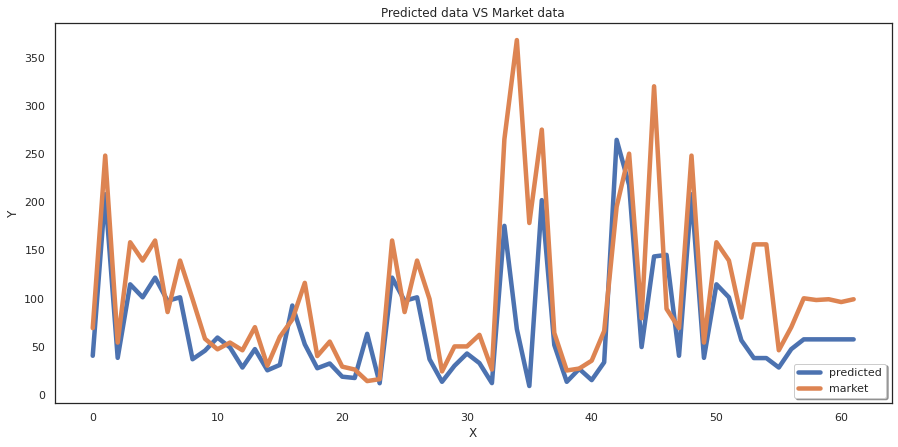

In [114]:
x_ax = range(len(result))
plt.figure(figsize=(15,7))
plt.plot(x_ax, result,linewidth = '4.5', label="predicted")
plt.plot(x_ax, tw_price, linewidth = '4.5', label="market")
plt.title("Predicted data VS Market data")
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc='lower right',fancybox=True, shadow=True)
plt.show() 